In [3]:
from metodos.SSLTree.utils.Experiments import cross_val, cross_val_ssl, names

from scipy.stats import rankdata
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp

# Comparativa entre SSLTree, DT y SelfTraining

In [18]:
# entropy
# gini
CRITERION = "entropy"

In [ ]:
all_means = {}

for i, p in enumerate(["10", "20", "30", "40"]):
    print("PERCENTAGE:", p)
    means_ssl = []
    means_dt = []
    means_st = []
    for name in names:
        print("\tDATASET:", name)
        m_ssl, m_dt, m_st = cross_val(name, p, criterion=CRITERION)

        np.save(f"comparativa/{CRITERION}/{p}/{name}_means.npy", np.array([m_ssl, m_dt, m_st]))

        means_ssl.append(m_ssl)
        means_dt.append(m_dt)
        means_st.append(m_st)

    all_means[p] = np.stack((means_ssl, means_dt, means_st))
np.save(f"comparativa/{CRITERION}/all_means.npy", all_means)
print("Resultados guardados")

In [19]:
def plot_comparativa(name):
    means = []
    for p in ["10", "20", "30", "40"]:
        means.append(np.load(f"comparativa/{CRITERION}/{p}/{name}_means.npy"))
    means = np.array(means).T
    
    classifiers = ["SSLTree", "DecisionTree", "SelfTraining"]
    for j, classifier in enumerate(classifiers):
        plt.plot(["10%", "20%", "30%", "40%"], means[j],marker='o', label=classifier)
    
    plt.xlabel("Porcentaje de etiquetados")
    plt.ylabel("Accuracy")
    plt.title("Dataset: " + name)
    
    plt.legend()
    plt.show()

In [105]:
plot_comparativa("appendicitis")

In [108]:
plot_comparativa("australian")

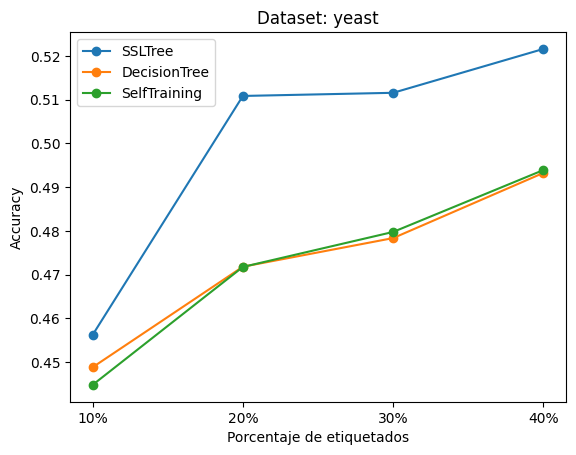

In [20]:
plot_comparativa("yeast")

In [16]:
all_means = np.load(f"comparativa/{CRITERION}/all_means.npy", allow_pickle=True).item()
all_mean_rankings = np.empty((3, 4))

for i, p in enumerate(["10", "20", "30", "40"]):
    rankings = rankdata(-all_means[p], method="average", axis=0)
    
    all_mean_rankings[:, i] = np.mean(rankings, axis=1)

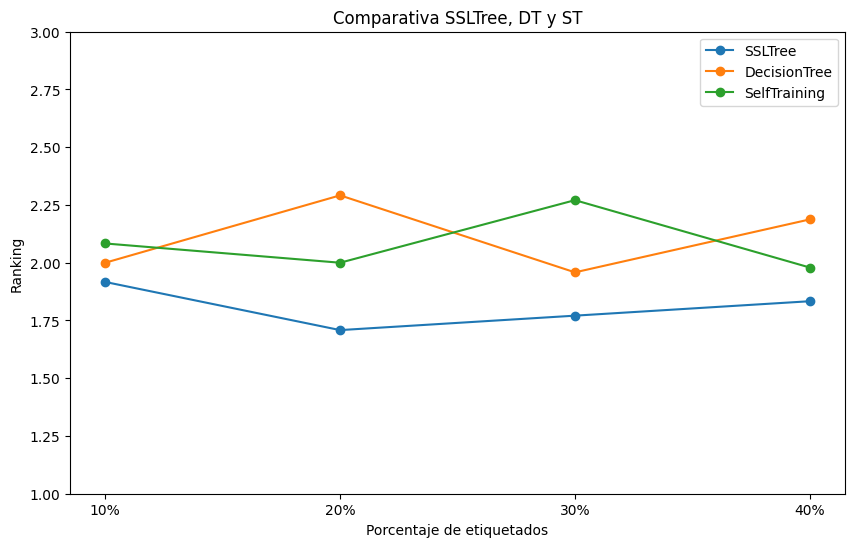

In [17]:
plt.figure(figsize=(10, 6))

classifiers = ["SSLTree", "DecisionTree", "SelfTraining"]
for j, classifier in enumerate(classifiers):
    plt.plot(["10%", "20%", "30%", "40%"], all_mean_rankings[j], marker="o", label=classifier)

plt.ylim(1, 3)
plt.xlabel("Porcentaje de etiquetados")
plt.ylabel("Ranking")
plt.title("Comparativa SSLTree, DT y ST")

plt.legend()
plt.show()

# Nemenyi Test

In [7]:
def nemenyi_test(matrix, p, model_names):

    dict_data = {
        model_names[0]: matrix[0, :],
        model_names[1]: matrix[1, :],
        model_names[2]: matrix[2, :]
    }
    
    data_list = [dict_data[key] for key in dict_data]

    results = np.array(data_list).T

    nemenyi_result = sp.posthoc_nemenyi_friedman(results)
    
    colors = {
        model_names[0]: "#1f77b4",
        model_names[1]: "#ff7f0e",
        model_names[2]: "#2ca02c"
    }
    
    ranks = pd.DataFrame(-results).rank(axis=1, method='average').mean(axis=0)
    ranks.index = list(dict_data.keys())
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(10, 2), dpi=100)
        plt.title("Nemenyi Test para " + p + " de etiquetados", pad=10)
        sp.critical_difference_diagram(ranks, nemenyi_result, label_fmt_left='{label} [{rank:.3f}]  ',
                                       label_fmt_right='  [{rank:.3f}] {label}', color_palette=colors)
        plt.show()

In [15]:
nemenyi_test(all_means["10"], "10%", ['SSLTree', 'DecisionTree', 'SelfTrainig(DT)'])
nemenyi_test(all_means["20"], "20%", ['SSLTree', 'DecisionTree', 'SelfTrainig(DT)'])
nemenyi_test(all_means["30"], "30%", ['SSLTree', 'DecisionTree', 'SelfTrainig(DT)'])
nemenyi_test(all_means["40"], "40%", ['SSLTree', 'DecisionTree', 'SelfTrainig(DT)'])

# Evaluación Bagging (SSLTree), CoForest(SSLTree) y SelfTraining (Random Forest)

In [3]:
all_means_ensembles = {}

for i, p in enumerate(["10", "20", "30", "40"]):
    print("PERCENTAGE:", p)
    means_randomforest= []
    means_coforest = []
    means_selftraining = []
    for name in names:
        print("\tDATASET:", name)
        m_randomforest, m_coforest, m_selftraining = cross_val_ssl(name, p, criterion=CRITERION)

        np.save(f"comparativa-ensembles/{CRITERION}/{p}/{name}_means.npy", np.array([m_randomforest, m_coforest, m_selftraining]))

        means_randomforest.append(m_randomforest)
        means_coforest.append(m_coforest)
        means_selftraining.append(m_selftraining)

    all_means_ensembles[p] = np.stack((means_randomforest, means_coforest, means_selftraining))
np.save(f"comparativa-ensembles/{CRITERION}/all_means.npy", all_means_ensembles)
print("Resultados guardados")

In [4]:
all_means_ensembles = np.load(f"comparativa-ensembles/{CRITERION}/all_means.npy", allow_pickle=True).item()
all_mean_rankings_ensembles = np.empty((3, 4))

for i, p in enumerate(["10", "20", "30", "40"]):
    rankings = rankdata(-all_means_ensembles[p], method="average", axis=0)
    
    all_mean_rankings_ensembles[:, i] = np.mean(rankings, axis=1)

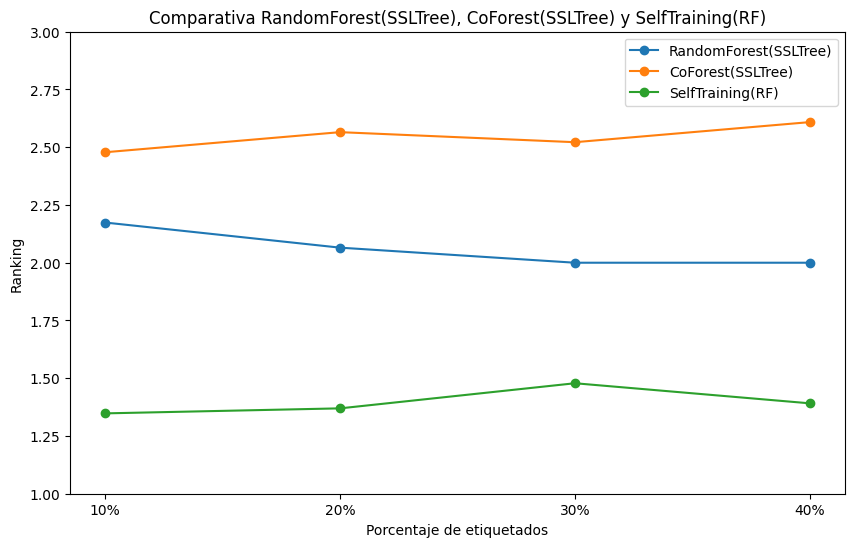

In [9]:
plt.figure(figsize=(10, 6))

classifiers = ["RandomForest(SSLTree)", "CoForest(SSLTree)", "SelfTraining(RF)"]
for j, classifier in enumerate(classifiers):
    plt.plot(["10%", "20%", "30%", "40%"], all_mean_rankings_ensembles[j], marker="o", label=classifier)

plt.ylim(1, 3)
plt.xlabel("Porcentaje de etiquetados")
plt.ylabel("Ranking")
plt.title("Comparativa RandomForest(SSLTree), CoForest(SSLTree) y SelfTraining(RF)")

plt.legend()
plt.show()

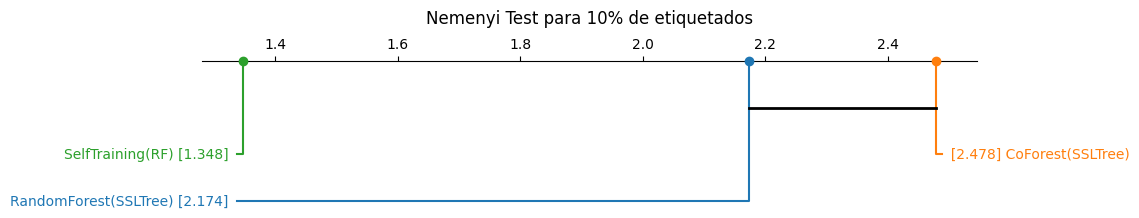

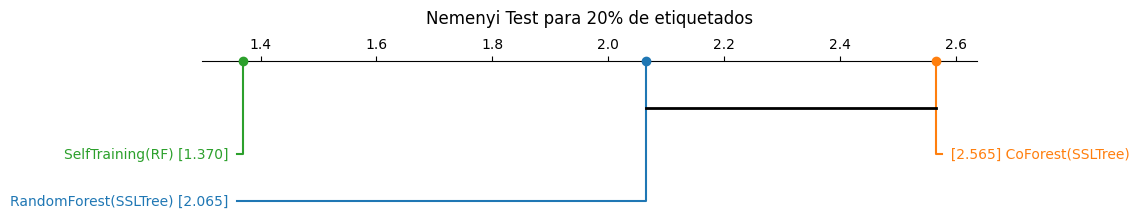

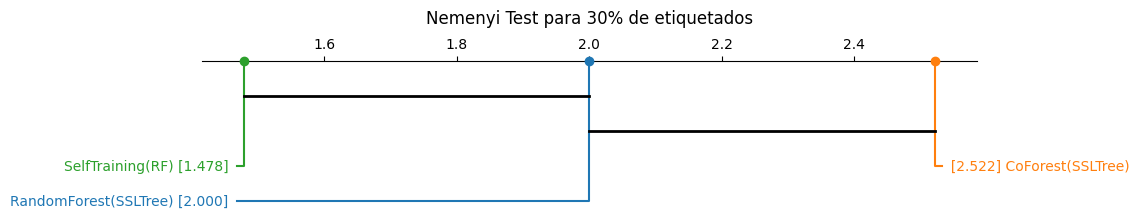

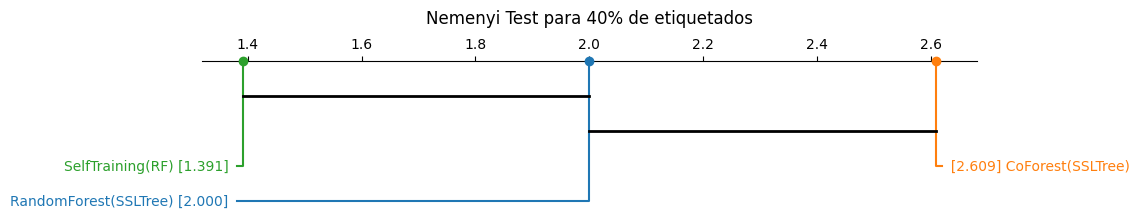

In [8]:
nemenyi_test(all_means_ensembles["10"], "10%", ["RandomForest(SSLTree)", "CoForest(SSLTree)", "SelfTraining(RF)"])
nemenyi_test(all_means_ensembles["20"], "20%", ["RandomForest(SSLTree)", "CoForest(SSLTree)", "SelfTraining(RF)"])
nemenyi_test(all_means_ensembles["30"], "30%", ["RandomForest(SSLTree)", "CoForest(SSLTree)", "SelfTraining(RF)"])
nemenyi_test(all_means_ensembles["40"], "40%", ["RandomForest(SSLTree)", "CoForest(SSLTree)", "SelfTraining(RF)"])